### look at the wavelength dependence of flux and slit position

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii, fits
from matplotlib.gridspec import GridSpec
from scipy import interpolate
from astropy.visualization import MinMaxInterval, AsinhStretch, HistEqStretch, ImageNormalize
from scipy.optimize import curve_fit
%matplotlib inline
#%matplotlib ipympl

In [19]:
# load atmospheric transmission file
path = '/Users/jpw/idl/Spextool/data/'
file = 'atran75000'
hdu = fits.open(path+file+'.fits')
tdata = hdu[0].data
atrans = interpolate.interp1d(tdata[0,:], tdata[1,:])
hdu.close()

In [20]:
# specify the rectified image and associated wavecal file
path = '../191008/'
#source = 'rectified1-2'
source = 'DRTau_PA90'
calfile = 'wavecal1-28'

hdu1 = fits.open(path+'reduced/'+source+'_combined.fits')
flux = hdu1[0].data
var = hdu1[1].data
rect_hd = hdu1[0].header
#flux_norm = ImageNormalize(flux, interval=MinMaxInterval(), stretch=HistEqStretch(flux))
flux_norm = ImageNormalize(flux, vmin=-10, vmax=10, stretch=AsinhStretch(0.3))

hdu2 = fits.open(path+'cal/'+calfile+'.fits')
wc_hd = hdu2[0].header
orders = wc_hd['ORDERS'].split(',')
norders = wc_hd['NORDERS']

In [21]:
j1 = 30           # starting point of first order -- figured out by hand
dj_AB = 121       # width of each order -- this should match the size of the number of rows in the order extension
dj_blank = 30     # gap between orders -- this is figured out by eye and assumed to be the same for all orders

Order = 105, Min/Max wavelength = 4.894352483435795, 4.935863121740658
0.0


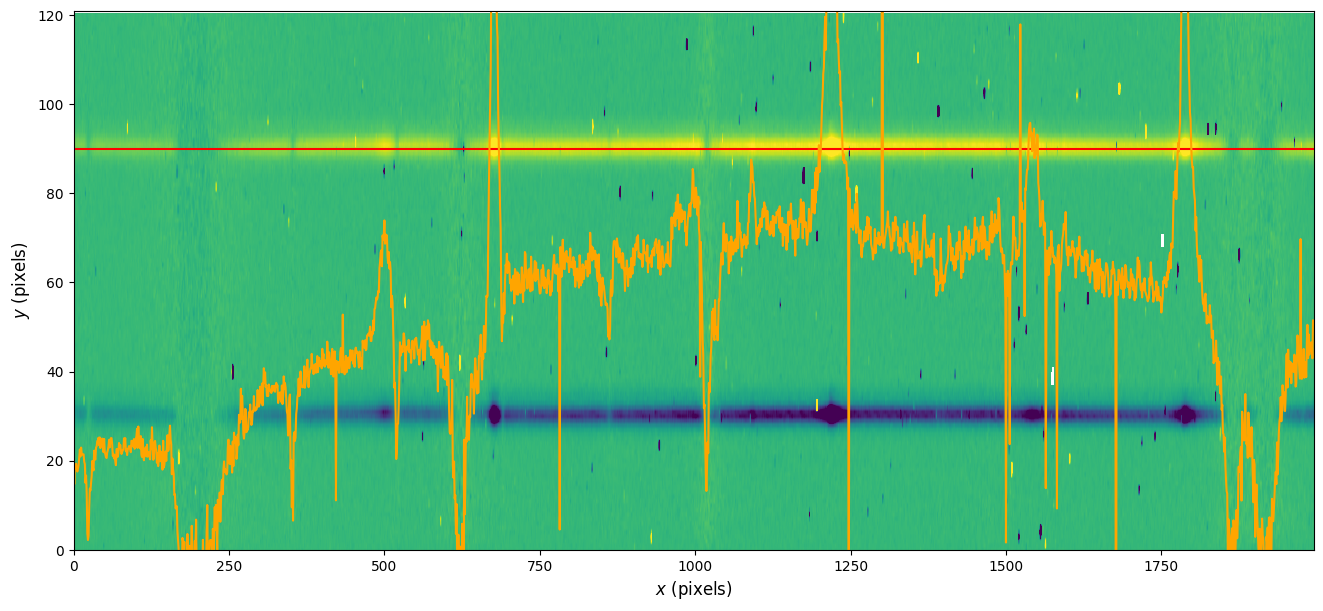

In [22]:
# note that the wavelength array does not have a constant width!
# so we should not use extent in imshow to set the x-axis labels
# they need to be specified in a more careful (non-linear) way
order = 105
norder = orders.index(str(order))

j0 = j1 + (dj_AB + dj_blank) * norder
order_flux = flux[j0:j0+dj_AB, :]
order_var = var[j0:j0+dj_AB, :]

wavecal = hdu2[3+norder].data
wl = wavecal[0, 0, 1:]
slitpos = wavecal[0, 1:, 0]
print(f'Order = {order}, Min/Max wavelength = {wl.min()}, {wl.max()}')
extent = [wl.min(), wl.max(), slitpos.min(), slitpos.max()]

fig, ax = plt.subplots(figsize=(16, 7))

# this is wrong
#ax.imshow(order_flux, origin='lower', norm=flux_norm, extent=extent, aspect='auto')
#ax.set_xlabel(r"$\lambda$ ($\mu$m)", fontsize=12)
#ax.set_ylabel(r"Slit offset ('')", fontsize=12)

# just work in pixels for now
ax.imshow(order_flux, origin='lower', norm=flux_norm, aspect='auto')
ax.set_xlabel(r"$x$ (pixels)", fontsize=12)
ax.set_ylabel(r"$y$ (pixels)", fontsize=12)

# show a single row spectrum just to make sure imshow is working ok
# (this revealed the non-linear pixel-wavelength dependence)
check = True
if check:
    nrow = 90
    ax.plot([0, wl.size], [nrow, nrow], color='red')
    row = order_flux[nrow, :].copy()
    row += np.min(row)
    row /= np.max(row)
    row -= np.median(row)
    print(np.median(row))
    ax.plot(np.arange(wl.size), 60 + 150*row, color='orange')
    ax.set_xlim(0, wl.size)
    ax.set_ylim(0, slitpos.size)

In [23]:
# note that the wavelength difference changes with wavelength
# the spectral resolving power, R, should be constant, but its not... maybe R=80000 at the center of the image
dwl = wl[1:] - wl[:-1]
R = wl[1:] / dwl / 3
print(dwl)
print(R)

[2.24918545e-05 2.24896604e-05 2.24874676e-05 ... 1.93682049e-05
 1.93666781e-05 1.93651508e-05]
[72535.51846089 72542.92815843 72550.33533788 ... 84947.20129202
 84954.23142423 84961.26503126]


In [24]:
# two gaussians with different peaks and offsets but same FWHM
def gauss2(x, A1, x1, A2, x2, fwhm, C):
    sigma = fwhm / (8*np.log(2))
    y = A1 * np.exp(-0.5*((x-x1)/sigma)**2) + A2 * np.exp(-0.5*((x-x2)/sigma)**2) + C
    return y

[-7.68057687e+00  3.03509567e+01  7.49741307e+00  9.04552842e+01
  9.94394639e+00  2.47027756e-03]
[0.10990213 0.03158642 0.10946391 0.03235808 0.12533744 0.01720277]


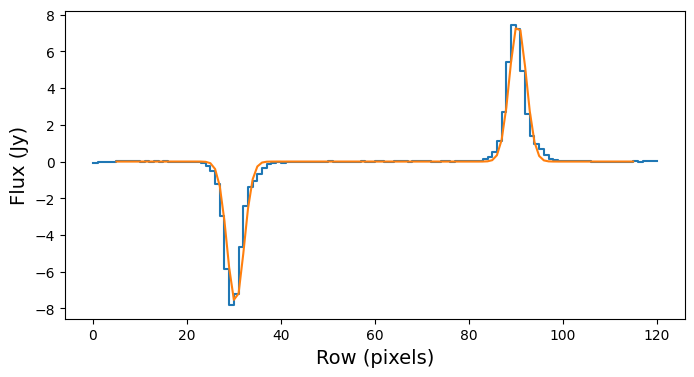

In [25]:
# stack in wavelength to get the continuum
im_median = np.nanmedian(order_flux, axis=1)
j = np.arange(im_median.size)
p0 = [np.min(im_median), np.argmin(im_median), np.max(im_median), np.argmax(im_median), 1, 0]

# don't fit within s_nofit of the edges
j_nofit = 4
fit_range = (j > j_nofit) & (j < j[-1]-j_nofit)

# fit two gaussians to the data
pfit_median, pcov = curve_fit(gauss2, j[fit_range], im_median[fit_range], p0)
perr = np.sqrt(np.diag(pcov))
gfit = gauss2(j[fit_range], *pfit_median)

fig, ax = plt.subplots(figsize=(8, 4))
ax.step(j, im_median)
ax.plot(j[fit_range], gfit)
ax.set_xlabel(r"Row (pixels)", fontsize=14)
ax.set_ylabel(r"Flux (Jy)", fontsize=14)

print(pfit_median)
print(perr)

(0.0, 1995.0)

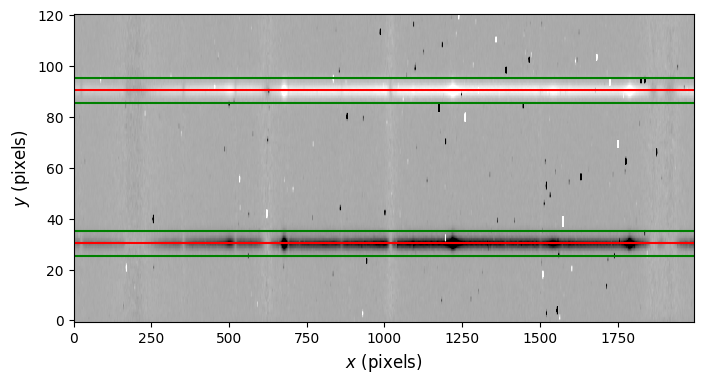

In [26]:
# aperture for calculating the spectrum; within two FWHM of the median peak
# recalculate the SA correction factor; C = 1.25 for one FWHM (Pontoppidan et al. 2008)
nfwhm = 1
C = 1.0
jneg =  pfit_median[1] + np.array([0, -0.5*nfwhm, 0.5*nfwhm]) * pfit_median[4]
jpos =  pfit_median[3] + np.array([0, -0.5*nfwhm, 0.5*nfwhm]) * pfit_median[4]

# make the index range integers for

nx = order_flux.shape[1]
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(order_flux, origin='lower', norm=flux_norm, aspect='auto', cmap='gray')
col = ['r', 'g', 'g']
for i in range(3):
    ax.plot([0, nx], [jneg[i], jneg[i]], color=col[i])
    ax.plot([0, nx], [jpos[i], jpos[i]], color=col[i])
ax.set_xlabel(r"$x$ (pixels)", fontsize=12)
ax.set_ylabel(r"$y$ (pixels)", fontsize=12)
ax.set_xlim(0, nx)

In [27]:
# now go through the entire wavelength range for this order but in pixel space
# calculate the spectroastrometric signal over a FWHM aperture on the positive and negative side

imfit = np.zeros(order_flux.shape)
nx = order_flux.shape[1]
spectrum = np.zeros((4, nx)) + np.nan
SA  = np.zeros((4, nx)) + np.nan

for n in range(nx):
    flux_slice = order_flux[:, n]
    weights = 1 / order_var[:, n]

    # integrate along an aperture on the negative and positive images to get the spectrum (and error)
    wneg = weights[int(jneg[1]+0.5):int(jneg[2]+1.5)]
    wpos = weights[int(jpos[1]+0.5):int(jpos[2]+1.5)]
    spectrum[0, n] = np.sum(wneg*flux_slice[int(jneg[1]+0.5):int(jneg[2]+1.5)]) / np.sum(wneg)
    spectrum[1, n] = np.sum(wpos*flux_slice[int(jpos[1]+0.5):int(jpos[2]+1.5)]) / np.sum(wpos)
    spectrum[2, n] = 1 / np.sum(wneg)
    spectrum[3, n] = 1 / np.sum(wpos)

    # calculate SA signal and error on the negative image
    jsum1 = 0
    jsum2 = 0
    fsum = 0.
    for j1 in range(int(jneg[1]+0.5), int(jneg[2]+1.5)):
        f1 = flux_slice[j1]
        jsum1 += (j1-jneg[0]) * f1
        jsum2 += (j1-jneg[0])**2 * f1
        fsum += f1
    jmean = jsum1 / fsum
    SA[0, n] = jmean
    SA[2, n] = np.sqrt((jsum2 / fsum - jmean**2) / (jneg[2] - jneg[1] + 1))

    # calculate SA signal and error on the positive image
    jsum1 = 0
    jsum2 = 0
    fsum = 0.
    for j1 in range(int(jpos[1]+0.5), int(jpos[2]+1.5)):
        f1 = flux_slice[j1]
        jsum1 += (j1-jpos[0]) * f1
        jsum2 += (j1-jpos[0])**2 * f1
        fsum += f1
    jmean = jsum1 / fsum
    SA[1, n] = jmean
    SA[3, n] = np.sqrt((jsum2 / fsum - jmean**2) / (jpos[2] - jpos[1] + 1))


/var/folders/tx/plmj8k8969gcvbqj4tml5hvm0000gn/T/ipykernel_16710/3801368674.py:32: RuntimeWarning: invalid value encountered in sqrt
  SA[2, n] = np.sqrt((jsum2 / fsum - jmean**2) / (jneg[2] - jneg[1] + 1))
/var/folders/tx/plmj8k8969gcvbqj4tml5hvm0000gn/T/ipykernel_16710/3801368674.py:45: RuntimeWarning: invalid value encountered in sqrt
  SA[3, n] = np.sqrt((jsum2 / fsum - jmean**2) / (jpos[2] - jpos[1] + 1))


In [28]:
# flags for data quality, note high snr needed for SA
flag1 = atrans(wl) < 0.5
flag2 = -spectrum[0, :] / spectrum[2, :] < 100
flag3 = spectrum[1, :] / spectrum[3, :] < 100
bad = [np.any([flag1[i], flag2[i], flag3[i]]) for i in range(len(flag1))]
SA[:, bad] = np.nan

Text(0, 0.5, 'Flux (Jy)')

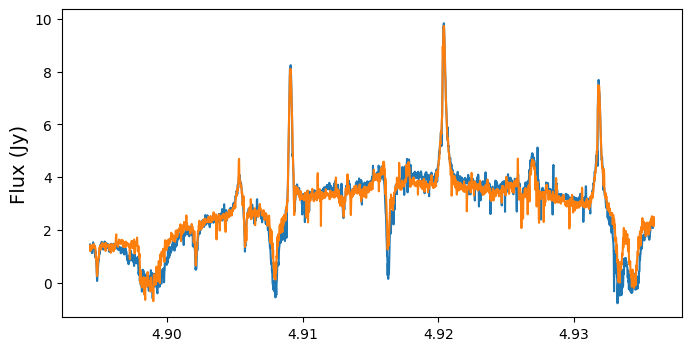

In [29]:
# plot the spectrum - not yet divided by the standard
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(wl, -spectrum[0, :])
ax.plot(wl, spectrum[1, :])
ax.set_ylabel(r"$\lambda$ ($\mu$m)", fontsize=14)
ax.set_ylabel(r"Flux (Jy)", fontsize=14)

(0.0, 121.0)

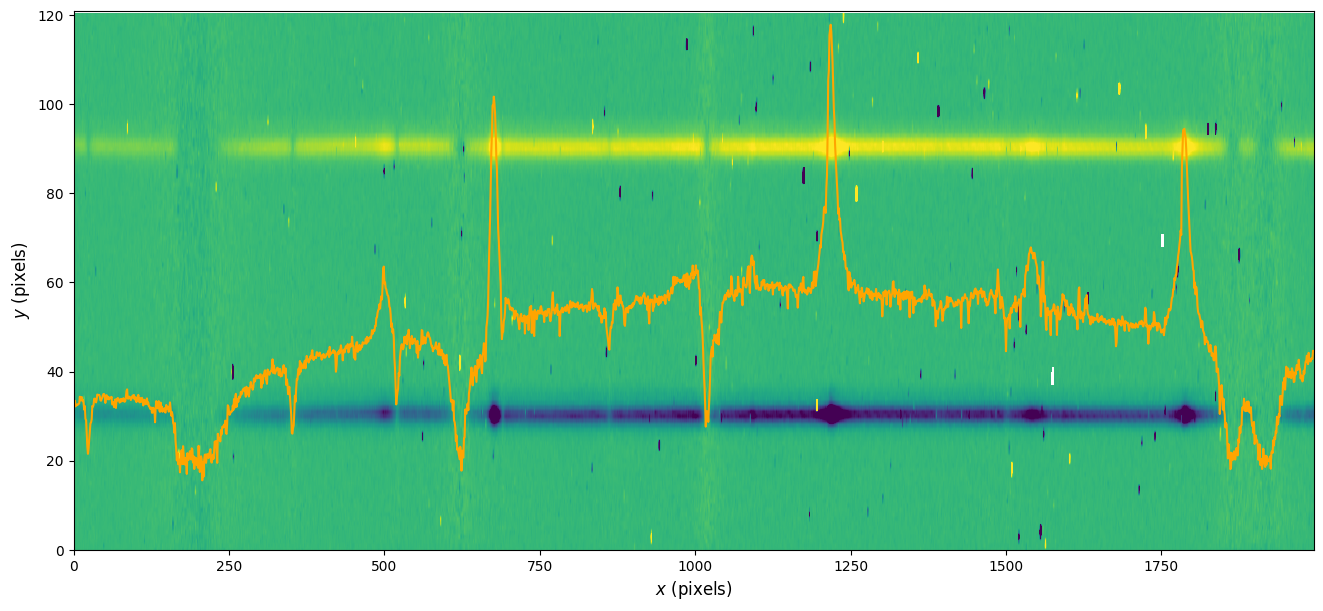

In [30]:
spectrum_ave = 0.5 * (spectrum[1, :] - spectrum[0, :])

fig, ax = plt.subplots(figsize=(16, 7))
ax.imshow(order_flux, origin='lower', norm=flux_norm, aspect='auto')
ax.set_xlabel(r"$x$ (pixels)", fontsize=12)
ax.set_ylabel(r"$y$ (pixels)", fontsize=12)

ax.plot(np.arange(order_flux.shape[1]), 20 + 10 * spectrum_ave, color='orange')
ax.set_xlim(0, order_flux.shape[1])
ax.set_ylim(0, order_flux.shape[0])

Text(0, 0.5, 'Flux (Jy)')

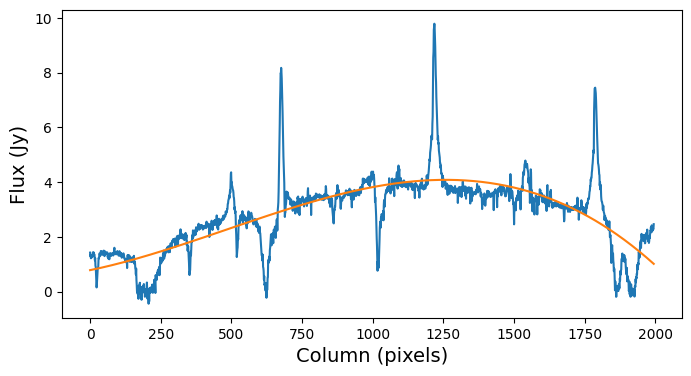

In [31]:
# spline fit the average spectrum so we can subtract the continuum
# https://www.datatechnotes.com/2021/11/scattered-data-spline-fitting-example.html
x = np.arange(spectrum_ave.size)
fit = np.isfinite(spectrum_ave)
xfit = x[fit]
spectrum_ave_fit = spectrum_ave[fit]

# experimenting with the number of knots, I find smaller is better
knot_numbers = 1
q = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(xfit, q) 
t, c, k = interpolate.splrep(xfit, spectrum_ave_fit, t=q_knots, s=1)
spectrum_spline_fit = interpolate.BSpline(t, c, k)(x)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, spectrum_ave)
ax.plot(x, spectrum_spline_fit)
ax.set_xlabel(r"Column (pixels)", fontsize=14)
ax.set_ylabel(r"Flux (Jy)", fontsize=14)

(0.0, 121.0)

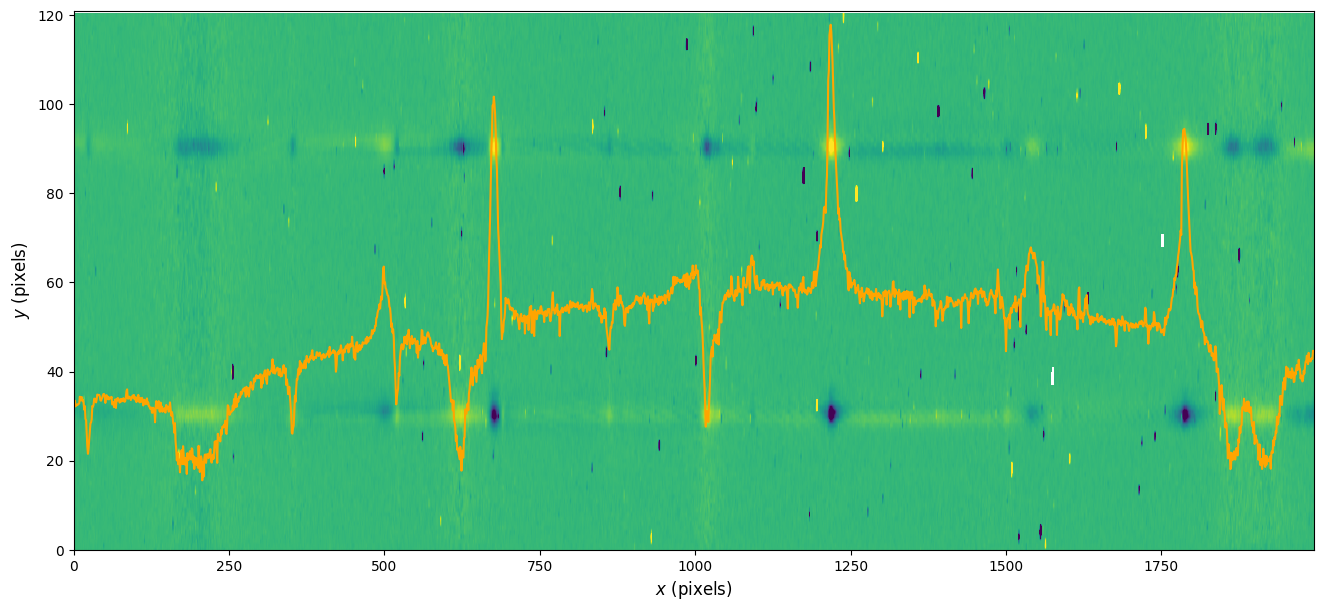

In [32]:
# remove the spline from the data
scale = np.nanmedian(order_flux, axis=1) / np.median(spectrum_spline_fit)
order_flux_sub = np.zeros(order_flux.shape)
for j in range(order_flux.shape[0]):
    order_flux_sub[j, :] = order_flux[j, :] - scale[j] * spectrum_spline_fit

fig, ax = plt.subplots(figsize=(16, 7))
ax.imshow(order_flux_sub, origin='lower', norm=flux_norm, aspect='auto')
ax.set_xlabel(r"$x$ (pixels)", fontsize=12)
ax.set_ylabel(r"$y$ (pixels)", fontsize=12)

ax.plot(x, 20 + 10 * spectrum_ave, color='orange')
ax.set_xlim(0, order_flux.shape[1])
ax.set_ylim(0, order_flux.shape[0])

Text(0, 0.5, 'Row offset (pixels)')

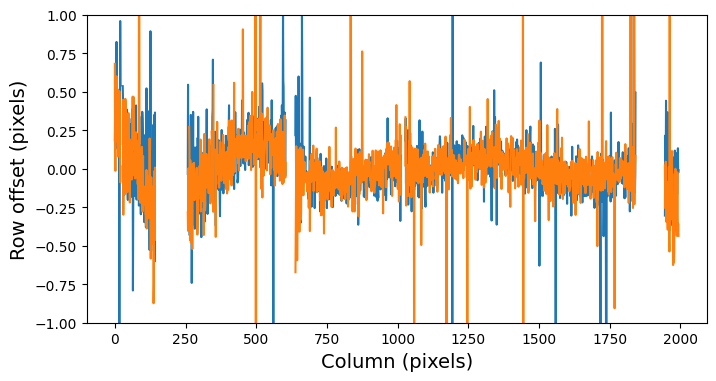

In [33]:
# plot the SA signal
fig, ax = plt.subplots(figsize=(8, 4))

# absolute positions on the slit
#ax.plot(x, SA[0, :])
#ax.plot(x, SA[1, :])
#ax.set_ylim(0,15)

# take away their median to show overlap
SA[0, :] -= np.nanmedian(SA[0, :])
SA[1, :] -= np.nanmedian(SA[1, :])
ax.plot(x, SA[0, :])
ax.plot(x, SA[1, :])
ax.set_ylim(-1, 1)
ax.set_xlabel(r"Column (pixels)", fontsize=14)
ax.set_ylabel(r"Row offset (pixels)", fontsize=14)

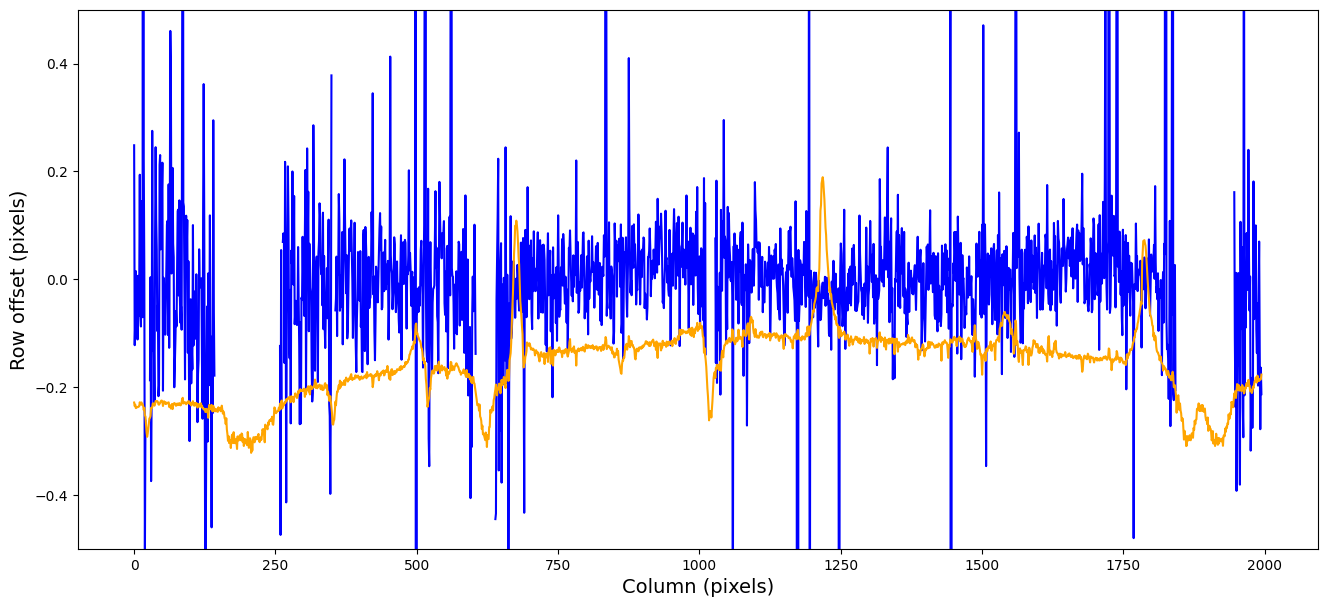

In [34]:
# plot the combined SA signal
SA_comb = 0.5 * (SA[1, :] - SA[0, :])
SA_comb_err = 0.5 * np.sqrt(SA[3, :]**2 + SA[2, :]**2)

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(x, SA_comb, color='b')
#ax.errorbar(x, SA_comb, yerr=SA_comb_err, color='b', ecolor='r', barsabove=True)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel(r"Column (pixels)", fontsize=14)
ax.set_ylabel(r"Row offset (pixels)", fontsize=14)

ax.plot(x, -0.3+0.05*spectrum_ave, color='orange')

#axr = ax.twinx()
#axr.plot(wl, 100*atrans(wl), '-', color='gray', alpha=0.5)
#axr.set_ylabel(r'Transmission (%)', fontsize=14)
#axr.set_ylim(-400,100)
#axr.set_yticks([-400,-300,-200,-100,0,100])
#axr.set_yticklabels(['','','','','0','100'])